In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()

    # 조건 필터링
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    # 불필요한 컬럼 제거
    cols_to_drop = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

    # 선수명 기준 평균 후 중복 제거
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)

    return df

# df1, df2 전처리
df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_29484\3835710417.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


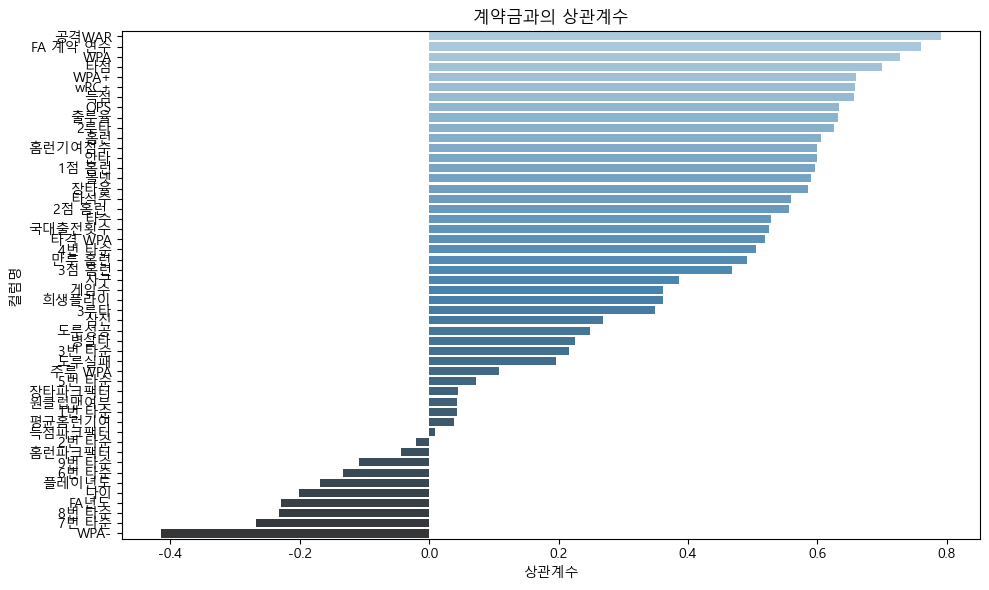

In [5]:
# 계약금과 상관계수 계산 
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화: 계약금과의 상관계수
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [6]:
# 상관계수 기반 가중치 계산
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})
print("상관계수 기반 가중치:")
print(weight_df)

# df1, df2 공통 컬럼만 추출
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
print(f"예측에 사용될 공통 피처: {predict_features}")

상관계수 기반 가중치:
         컬럼명       가중치
0      공격WAR  0.040855
1   FA 계약 연수  0.039275
2        WPA  0.037568
3         타점  0.036160
4       WPA+  0.034056
5       wRC+  0.033973
6         득점  0.033944
7        OPS  0.032738
8        출루율  0.032661
9        2루타  0.032353
10        홈런  0.031318
11    홈런기여점수  0.030976
12        안타  0.030939
13     1점 홈런  0.030799
14        볼넷  0.030449
15       장타율  0.030230
16       타석수  0.028906
17    2점 홈런   0.028724
18        타수  0.027303
19    국대출전횟수  0.027093
20    타격 WPA  0.026799
21     4번 타순  0.026125
22     만루 홈런  0.025381
23     3점 홈런  0.024150
24        사구  0.019909
25       게임수  0.018696
26     희생플라이  0.018636
27       3루타  0.018032
28        삼진  0.013870
29      도루성공  0.012825
30       병살타  0.011638
31     3번 타순  0.011183
32      도루실패  0.010136
33    주루 WPA  0.005569
34     5번 타순  0.003776
35    장타파크팩터  0.002330
36    원클럽맨여부  0.002259
37     1번 타순  0.002211
38    평균홈런기여  0.001993
39    득점파크팩터  0.000481
40     2번 타순  0.001028
41    홈런파크팩터  0.00222

In [7]:
# 학습/검증 데이터 준비
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df2_cleaned[predict_features])

In [8]:
# XGBoost 모델 학습 (튜닝 없이 기본 파라미터)
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# 성능 확인
val_pred = xgb_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"[XGBoost] 검증 RMSE: {rmse:,.2f}")

# 예측 결과 저장
df2_cleaned['계약금'] = xgb_model.predict(X_test_scaled)

[XGBoost] 검증 RMSE: 131,957.87


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\Lee\AppData\Local\Temp\ipykernel_29484\2659472911.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='중요도 (XGBoost)', y='컬럼명', palette='PuBuGn_r')



📈 피처 중요도 (XGBoost):
       컬럼명  중요도 (XGBoost)  상관계수 기반 가중치
17  국대출전횟수   1.952446e-01     0.027093
0    공격WAR   1.947380e-01     0.040855
38  홈런파크팩터   1.011394e-01     0.002225
8      2루타   8.157837e-02     0.032353
22      사구   8.118823e-02     0.019909
6      OPS   7.057464e-02     0.032738
36  득점파크팩터   5.744603e-02     0.000481
26      삼진   3.787632e-02     0.013870
2       타점   3.265061e-02     0.036160
3     WPA+   3.188424e-02     0.034056
5       득점   1.988536e-02     0.033944
30    도루실패   1.797277e-02     0.010136
4     wRC+   1.675390e-02     0.033973
43    FA년도   9.216805e-03     0.011807
19   4번 타순   8.922474e-03     0.026125
7      출루율   8.139257e-03     0.032661
24   희생플라이   7.512928e-03     0.018636
46    WPA-   3.658426e-03     0.021428
12   1점 홈런   3.053265e-03     0.030799
13      볼넷   1.902823e-03     0.030449
25     3루타   1.825191e-03     0.018032
20   만루 홈런   1.760853e-03     0.025381
31  주루 WPA   1.644596e-03     0.005569
1      WPA   1.607765e-03     0.037568
23  

C:\Users\Lee\AppData\Local\Temp\ipykernel_29484\2659472911.py:17: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


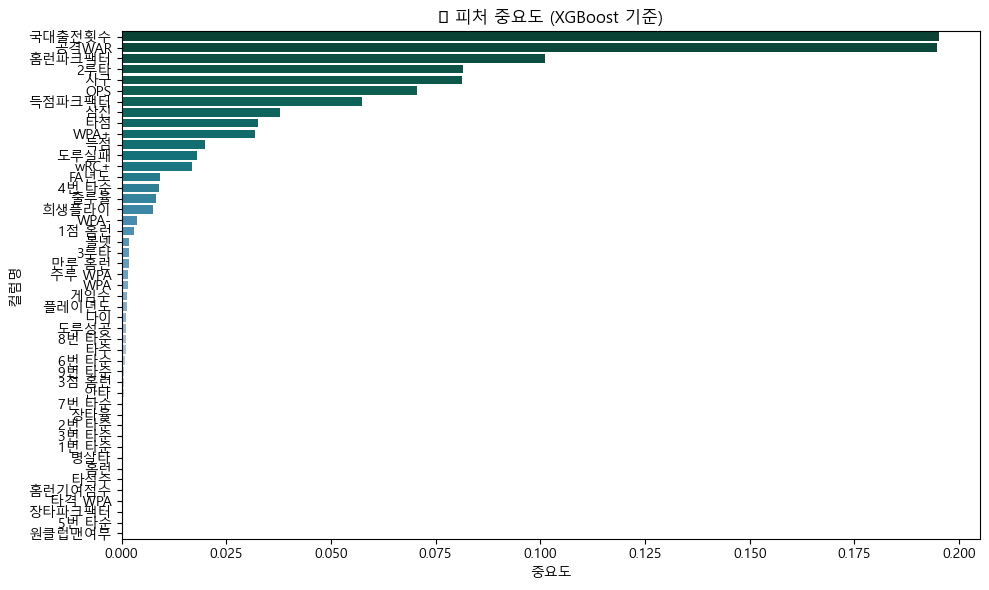

In [10]:
# 피처 중요도
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (XGBoost)': xgb_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (XGBoost)', ascending=False)

print("\n📈 피처 중요도 (XGBoost):")
print(importance_df)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='중요도 (XGBoost)', y='컬럼명', palette='PuBuGn_r')
plt.title('🎯 피처 중요도 (XGBoost 기준)')
plt.xlabel('중요도')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 확인
print("예측 계약금 상위 선수 (XGBoost):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='계약금', ascending=False))

예측 계약금 상위 선수 (XGBoost):
    선수명            계약금
6   박해민  275132.312500
0   강민호  205148.187500
3   박병호  193550.203125
13  최형우  191722.875000
9   장성우  180454.828125
2   김재환  169866.328125
5   박찬호  163673.421875
7   손아섭  122705.304688
12  최원준  117605.132812
14  황재균   93588.843750
1   강백호   89907.273438
8   이재원   87287.875000
11  조수행   34562.765625
4   박승욱   34498.683594
10   정훈   28938.175781
